In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier

warnings.filterwarnings("ignore")


In [2]:
train_df = pd.read_csv("Training.csv")
test_df = pd.read_csv("Testing.csv")

train_df = train_df.loc[:, ~train_df.columns.str.contains('^Unnamed')]
test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]


In [5]:
X_train = train_df.iloc[:, :-1]
y_train = train_df["prognosis"]

X_test = test_df.iloc[:, :-1]
y_test = test_df["prognosis"]


In [7]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train_encoded)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test_encoded, y_pred)
print(f"Model Accuracy: {acc * 100:.2f}%")


Model Accuracy: 97.62%


In [11]:
mlb = MultiLabelBinarizer()
y_train_multilabel = mlb.fit_transform([[d] for d in y_train])
y_test_multilabel = mlb.transform([[d] for d in y_test])

multi_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
multi_model.fit(X_train, y_train_multilabel)


MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [12]:
symptoms_list = X_train.columns.tolist()


In [15]:
remedy_db = {
    "(vertigo) Paroymsal  Positional Vertigo": ("Vestibular therapy, rest, avoid head tilts", "Low"),
    "AIDS": ("Antiretroviral therapy, safe practices, regular monitoring", "Very High"),
    "Acne": ("Topical creams, clean skin, avoid oily foods", "Low"),
    "Alcoholic hepatitis": ("Stop alcohol, liver meds, consult hepatologist", "High"),
    "Allergy": ("Antihistamines, avoid allergens, hydration", "Medium"),
    "Arthritis": ("Pain relief, exercise, consult rheumatologist", "Medium"),
    "Bronchial Asthma": ("Inhalers, avoid triggers, regular check-ups", "High"),
    "Cervical spondylosis": ("Neck support, exercises, pain relief", "Medium"),
    "Chicken pox": ("Rest, calamine lotion, avoid scratching", "Medium"),
    "Chronic cholestasis": ("Medication for bile flow, avoid fatty food", "High"),
    "Common Cold": ("Rest, fluids, steam inhalation", "Low"),
    "Dengue": ("Fluids, platelet monitoring, consult doctor", "High"),
    "Diabetes ": ("Diet control, insulin or meds, check sugar levels", "High"),
    "Dimorphic hemmorhoids(piles)": ("Fiber-rich diet, sitz baths, surgery if needed", "Medium"),
    "Drug Reaction": ("Stop drug, emergency consult", "Very High"),
    "Fungal infection": ("Antifungal creams, hygiene, loose clothes", "Low"),
    "GERD": ("Avoid spicy food, antacids, upright posture", "Medium"),
    "Gastroenteritis": ("Hydration, light meals, antiemetics", "Medium"),
    "Heart attack": ("Emergency care, aspirin, call ambulance", "Very High"),
    "Hepatitis A": ("Rest, hydration, avoid alcohol", "Medium"),
    "Hepatitis B": ("Antivirals, liver care, specialist consultation", "High"),
    "Hepatitis C": ("Antivirals, regular liver tests", "High"),
    "Hepatitis D": ("Specialist treatment, avoid alcohol", "High"),
    "Hepatitis E": ("Clean water, rest, light meals", "Medium"),
    "Hypertension ": ("Low salt diet, meds, BP monitoring", "High"),
    "Hyperthyroidism": ("Beta blockers, thyroid meds", "High"),
    "Hypoglycemia": ("Sugar intake, glucose tabs, emergency care", "Very High"),
    "Hypothyroidism": ("Thyroxine tablets daily, check-ups", "High"),
    "Impetigo": ("Topical antibiotics, hygiene", "Medium"),
    "Jaundice": ("Avoid alcohol and fat, liver meds", "Medium"),
    "Malaria": ("Antimalarial drugs, mosquito nets", "High"),
    "Migraine": ("Pain relief, dark room, hydration", "Medium"),
    "Osteoarthristis": ("Exercise, weight control, pain relief", "Medium"),
    "Paralysis (brain hemorrhage)": ("Emergency hospitalization, neuro support", "Very High"),
    "Peptic ulcer diseae": ("Antacids, avoid NSAIDs, consult gastro", "Medium"),
    "Pneumonia": ("Antibiotics, rest, fluids", "High"),
    "Psoriasis": ("Topical creams, UV therapy, moisturizers", "Medium"),
    "Tuberculosis": ("6-month full treatment, mask use", "Very High"),
    "Typhoid": ("Antibiotics, soft diet, hygiene", "High"),
    "Urinary tract infection": ("Antibiotics, hydration, hygiene", "Medium"),
    "Varicose veins": ("Compression stockings, leg elevation", "Medium")
}


In [17]:
def predict_possible_diseases(input_symptoms):
    input_vector = [1 if symptom in input_symptoms else 0 for symptom in symptoms_list]
    input_vector = np.array(input_vector).reshape(1, -1)
    probabilities = model.predict_proba(input_vector)[0]
    threshold = 0.1
    probable_indices = [i for i, prob in enumerate(probabilities) if prob >= threshold]
    possible_diseases = le.inverse_transform(probable_indices)
    return list(possible_diseases)


In [27]:
def suggest_symptoms(partial_input):
    """Suggest symptoms based on partial input."""
    partial_input = partial_input.lower()
    matches = [symptom for symptom in symptoms_list if partial_input in symptom.lower()]
    return matches

# Example usage
partial = input("Type part of a symptom: ")
suggestions = suggest_symptoms(partial)

print("\nSuggested Symptoms:")
for s in suggestions:
    print(f" - {s}")


Type part of a symptom:  HEA



Suggested Symptoms:
 - headache
 - fast_heart_rate
 - blackheads


In [19]:
def get_recommendation(disease):
    return remedy_db.get(
        disease,
        ("Consult a healthcare provider for accurate diagnosis and treatment.", "Medium")
    )


In [21]:
urgency_levels = {
    "Low": 1,
    "Medium": 2,
    "High": 3,
    "Very High": 4
}

urgency_color_map = {
    "Low": "green",
    "Medium": "gold",
    "High": "orange",
    "Very High": "red"
}


In [23]:
user_input = input("Enter symptoms separated by commas (e.g., fever, cough, fatigue): ")
input_symptoms = [s.strip().lower() for s in user_input.split(",")]

matched_symptoms = [symptom for symptom in symptoms_list if any(inp in symptom.lower() for inp in input_symptoms)]

if not matched_symptoms:
    print("No matching symptoms found. Please try again with more specific terms.")
else:
    print(f"Using symptoms: {matched_symptoms}")


Enter symptoms separated by commas (e.g., fever, cough, fatigue):  HEADCHE, FEVER, COUGH


Using symptoms: ['cough', 'high_fever', 'mild_fever']


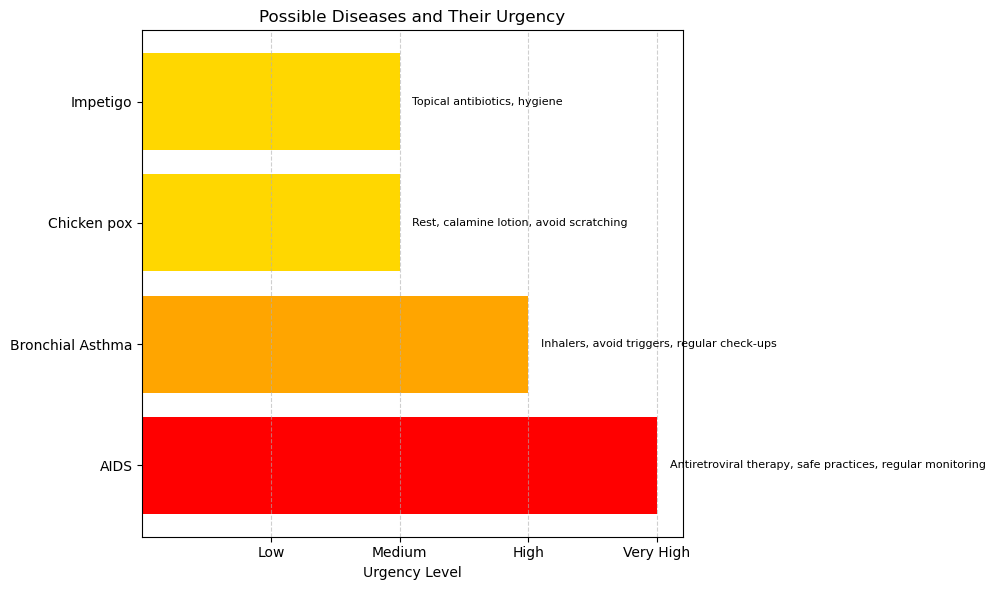

In [25]:
    matches = predict_possible_diseases(matched_symptoms)

    disease_names = []
    urgency_values = []
    urgency_colors = []

    for dis in matches:
        remedy, urgency = get_recommendation(dis)
        disease_names.append(dis)
        urgency_values.append(urgency_levels.get(urgency, 0))
        urgency_colors.append(urgency_color_map.get(urgency, "gray"))

    plt.figure(figsize=(10, 6))
    bars = plt.barh(disease_names, urgency_values, color=urgency_colors)
    plt.xlabel("Urgency Level")
    plt.title("Possible Diseases and Their Urgency")
    plt.yticks(fontsize=10)
    plt.xticks([1, 2, 3, 4], ["Low", "Medium", "High", "Very High"])
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    for i, bar in enumerate(bars):
        remedy, _ = get_recommendation(disease_names[i])
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f"{remedy}", va='center', fontsize=8)

    plt.tight_layout()
    plt.show()
